<a href="https://colab.research.google.com/github/artisanvaultcode/predestrianRCNN/blob/main/RCNN_Detecting_Pedestrians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip -qo "/content/drive/MyDrive/PedestrianDataset.zip" -d "/content/drive/MyDrive/Pedestrians"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd

import cv2
import os
from xml.etree import ElementTree
from matplotlib import pyplot as plt

In [17]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
keras = tf.keras

In [7]:
class_names = ['person','person-like']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

n_classes = 2
size = (120,120)

In [8]:
def load_data():
    datasets = ['/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Train/Train', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Test/Test', '/content/drive/MyDrive/Pedestrians/Pedestrian_Detection/Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = dataset +"/Annotations"
        directoryIMG = dataset +"/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:

            xmlf = os.path.join(directoryA,xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i +=1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')

        output.append((imags, labels))
    return output

In [9]:
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [11]:
train_images.shape

(944, 120, 120, 3)

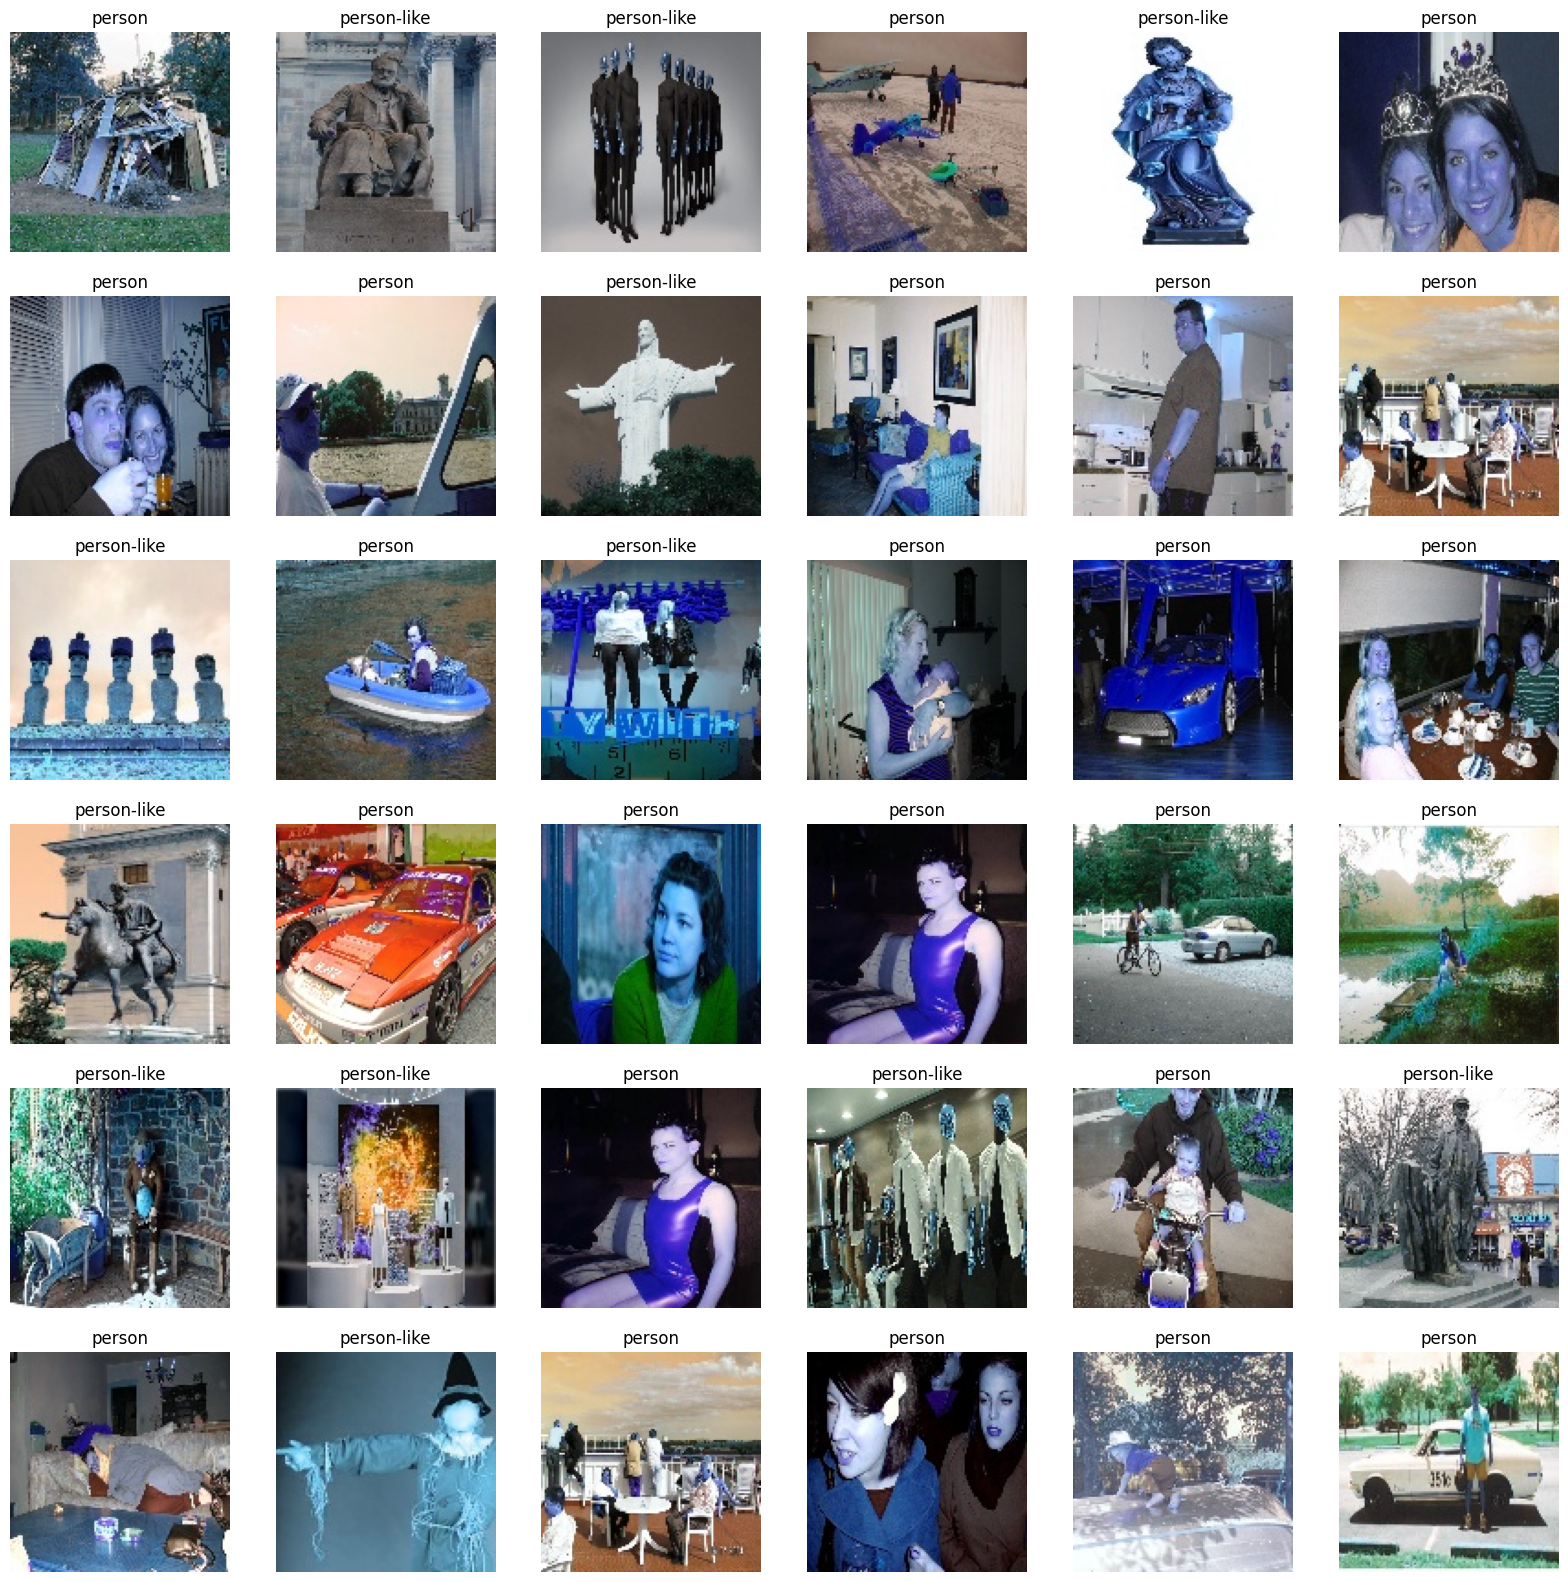

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')

In [15]:
#construct model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))
for layer in vgg_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [18]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=2)
filepath = "modelPedestrianDetection.h5"
ckpt = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
rlp = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1)

In [21]:
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

Epoch 1/10
30/30 [==============================] - 192s 6s/step - loss: 0.0730 - accuracy: 0.9809 - val_loss: 0.6361 - val_accuracy: 0.7660
Epoch 2/10
30/30 [==============================] - 192s 6s/step - loss: 0.0609 - accuracy: 0.9905 - val_loss: 0.6434 - val_accuracy: 0.7660
Epoch 3/10
30/30 [==============================] - 192s 6s/step - loss: 0.0469 - accuracy: 0.9905 - val_loss: 0.6591 - val_accuracy: 0.7660
Epoch 4/10
30/30 [==============================] - 192s 6s/step - loss: 0.0373 - accuracy: 0.9968 - val_loss: 0.7125 - val_accuracy: 0.7872
Epoch 5/10
30/30 [==============================] - 191s 6s/step - loss: 0.0282 - accuracy: 0.9989 - val_loss: 0.6886 - val_accuracy: 0.7660
Epoch 6/10
30/30 [==============================] - 191s 6s/step - loss: 0.0325 - accuracy: 0.9947 - val_loss: 0.7355 - val_accuracy: 0.7745
Epoch 7/10
30/30 [==============================] - 191s 6s/step - loss: 0.0208 - accuracy: 0.9989 - val_loss: 0.7667 - val_accuracy: 0.7660
Epoch 8/10
30

In [22]:
import joblib
joblib.dump(history, '/content/drive/MyDrive/Pedestrians/modelRCNNPedestrianDetectionAdam.pkl')

['/content/drive/MyDrive/Pedestrians/modelRCNNPedestrianDetectionAdam.pkl']

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_labels)

In [24]:
import numpy as np

X_train_vec = np.array([np.reshape(img, (-1,)) for img in train_images])

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

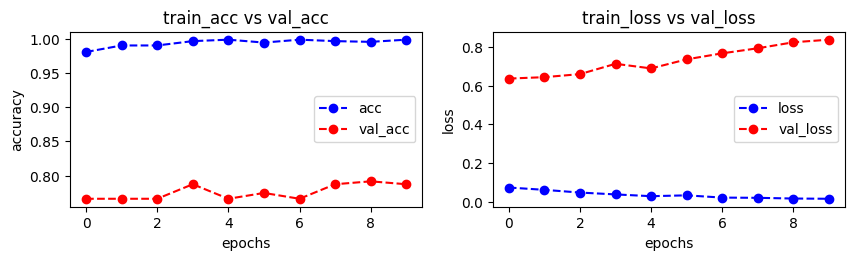

In [26]:
plot_accuracy_loss(history)

In [27]:
preds = model.predict(val_images)

5/5 [==============================] - 27s 5s/step


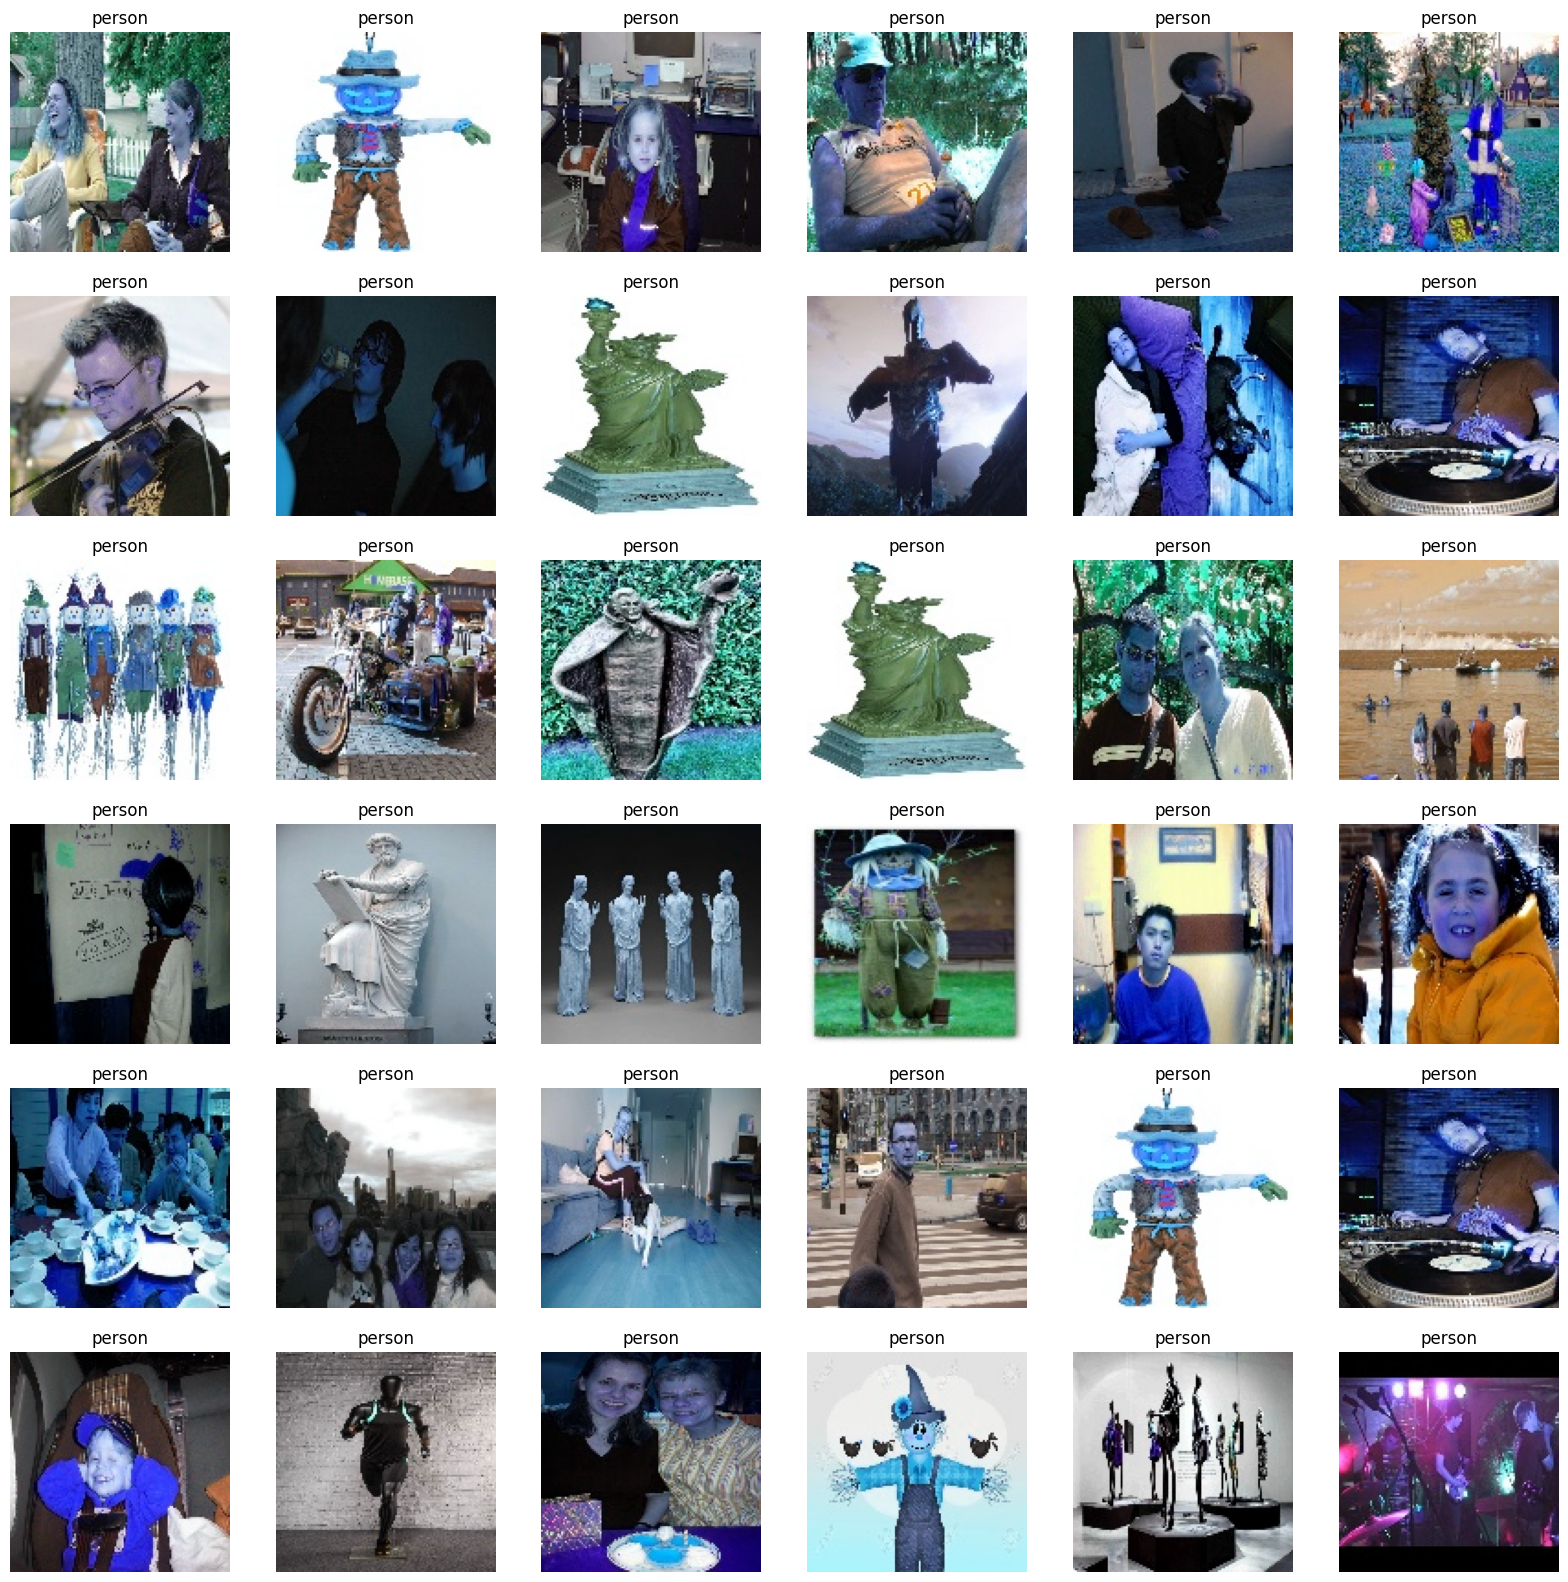

In [28]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])
    plt.axis('off')
    x =np.argmax(preds[i]) # takes the maximum of of the 6 probabilites.
    plt.title((class_names[x]))

In [29]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [30]:
tn, fp, fn, tp = confusion_matrix(val_labels,result).ravel()

In [33]:
(tn, fp, fn, tp)

(85, 0, 75, 0)